<a href="https://colab.research.google.com/github/phi1z/1yanagiLab/blob/main/AC_MH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

#@title File import
import pandas as pd
import numpy as np
import os

# ファイルの読み込み
os.makedirs("data", exist_ok=True)
os.makedirs("result", exist_ok=True)
from IPython.display import clear_output
clear_output()
files = os.listdir("data")
MRIs = [f for f in files if os.path.splitext(f)[1] == '.trc']
MRIs = np.sort(MRIs)
# ファイルの確認
print(f"ファイル数: {len(MRIs)}")
print(f"1: {MRIs[0]} ")
if len(MRIs) > 1:
  print(f"2: {MRIs[1]} ")
else:
  print("......")
if len(MRIs) > 2:
  print(f"3: {MRIs[2]} ")
  print("......")
else:
  print("......")
# indexの表示
data_dir = "data"
rows = []
for filename in os.listdir(data_dir):
    if filename.endswith(".trc"):
        name = os.path.splitext(filename)[0]
        parts = name.split("_")
        parts[2] = int(parts[2].replace("kHz", "")) * 1.0e3
        parts[3] = int(parts[3].replace("mT", ""))
        this_row = [filename, *parts]
        rows.append(this_row)
df = pd.DataFrame(rows, columns=["path", "type", "date", "f", "H", "sample"])
df = df.sort_values(by=["type", "f", "H", "sample"])
df = df.reset_index(drop=True)
display(df[df['type'] == "Mg"])


ファイル数: 36
1: BG_20260114_24kHz_05mT_blank.trc 
2: BG_20260114_24kHz_10mT_blank.trc 
3: BG_20260114_24kHz_10mT_blank2.trc 
......


,path,type,date,f,H,sample
32,Mg_20260115_46kHz_5mT_S1.trc,Mg,20260115,46000.0,5,S1
33,Mg_20260115_46kHz_10mT_S1.trc,Mg,20260115,46000.0,10,S1
34,Mg_20260115_96kHz_10mT_S1.trc,Mg,20260115,96000.0,10,S1
35,Mg_20260115_300kHz_10mT_S1.trc,Mg,20260115,300000.0,10,S1


In [3]:
#@title Select File

key = 33 #@param {type:"integer"}

MG = df.iloc[key]
condition = [MG['f'], MG['H'], MG['sample']]

print(np.array(condition))

Mg = df[(df['type'] == "Mg") & (df['f'] == condition[0]) &
        (df['H'] == condition[1]) & (df['sample'] == condition[2])]
BG = df[(df['type'] == "BG") & (df['f'] == condition[0]) &
        (df['H'] == condition[1])]
H1 = df[(df['type'] == "H1") & (df['f'] == condition[0]) &
        (df['H'] == condition[1])]
H2 = df[(df['type'] == "H2") & (df['f'] == condition[0]) &
        (df['H'] == condition[1]) & (df['sample'] == condition[2])]
All = pd.concat([BG, H1, H2, Mg])
All = All.reset_index(drop=True)
display(All)


['46000.0' '10' 'S1']


,path,type,date,f,H,sample
0,BG_20260115_46kHz_10mT_blank.trc,BG,20260115,46000.0,10,blank
1,H1_20260115_46kHz_10mT_blank.trc,H1,20260115,46000.0,10,blank
2,H2_20260115_46kHz_10mT_S1.trc,H2,20260115,46000.0,10,S1
3,Mg_20260115_46kHz_10mT_S1.trc,Mg,20260115,46000.0,10,S1


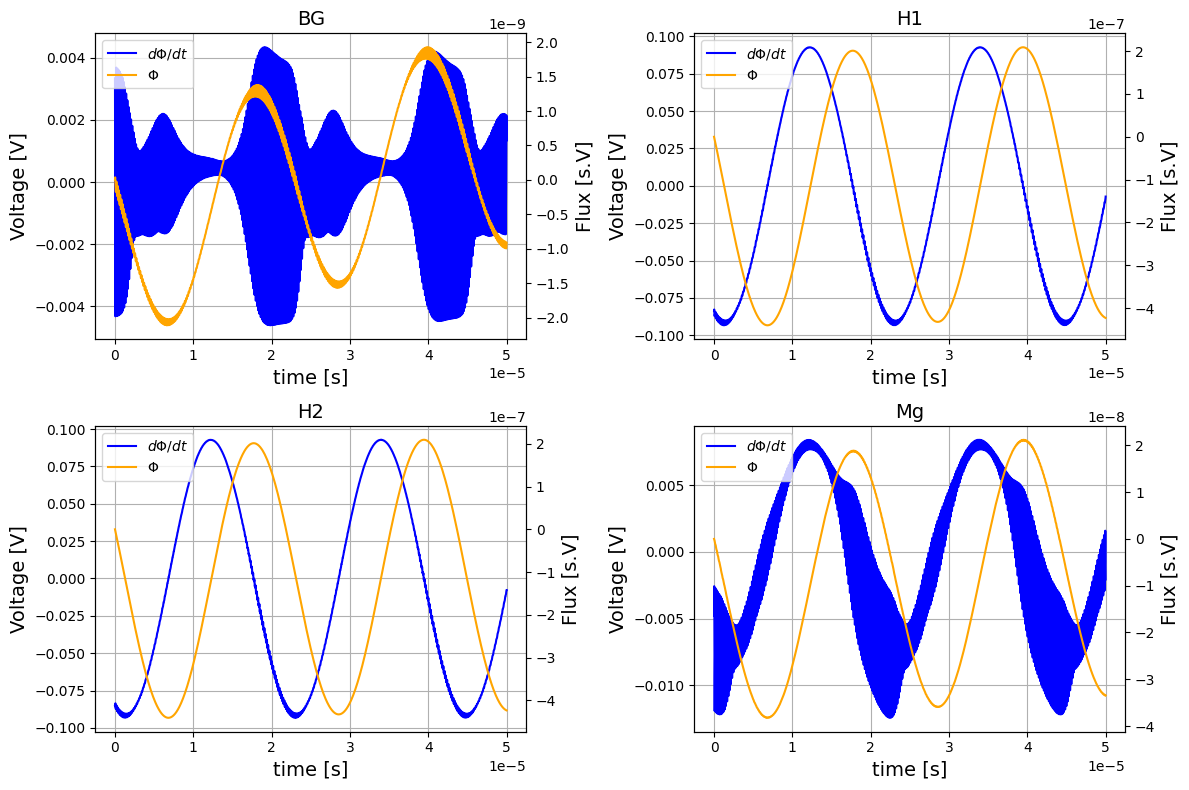

In [4]:
#@title Read Signal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate

def read_trc(path):
  df = pd.read_csv(path, skiprows=4, sep=",")
  df.columns = ["time", "amp"]
  df['time'] = df['time'] - df['time'][0]
  df = df.dropna().reset_index(drop=True)
  return df

def get_flux(df, ax, sampe=""):
  df['flux'] = np.cumsum(df['amp'] * df['time'].diff())
  df = df.dropna().reset_index(drop=True)
  df.head()

  ax.grid(True)
  ax.set_title(sampe, fontsize=14) # Changed title to set_title
  ax.plot(df['time'], df['amp'], label=r"$d\Phi/dt$", color="blue")
  ax2 = ax.twinx()
  ax2.plot(df['time'], df['flux'], label=r"$\Phi$", color="orange")
  ax.set_xlabel("time [s]", fontsize=14)
  ax.set_ylabel("Voltage [V]", fontsize=14)
  ax2.set_ylabel("Flux [s.V]", fontsize=14)
  # plot legend with one legend
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2)
  # plt.show() # Removed plt.show() from the function to show all subplots at once
  return df

path_list = []
for path in All['path']:
  path_list.append(f"data/{path}")

BG_df = read_trc(path_list[0])
H1_df = read_trc(path_list[1])
H2_df = read_trc(path_list[2])
Mg_df = read_trc(path_list[3])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

BG = get_flux(BG_df, axs[0, 0], "BG")
H1 = get_flux(H1_df, axs[0, 1], "H1")
H2 = get_flux(H2_df, axs[1, 0], "H2")
Mg = get_flux(Mg_df, axs[1, 1], "Mg")

plt.tight_layout() # Added for better layout
plt.show()

============ BG was done ============
============ H1 was done ============
============ H2 was done ============
============ Mg was done ============


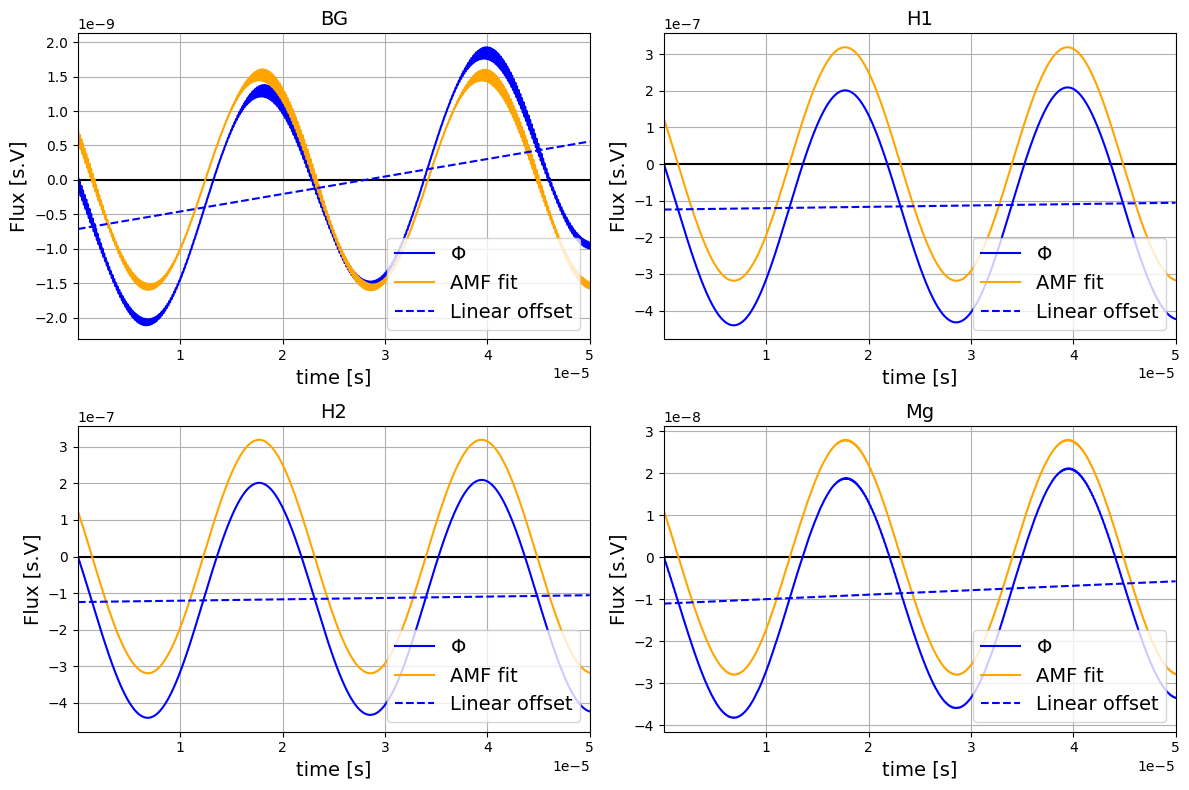

In [5]:
#@title liner offset

from matplotlib import axes

def fit_AMF(df, ax, freq, sampe="", p0=[1.0e-7, 1.0, 1.0e3, 1.0e-5]):
  def Liner_AMF(x, H, phi, a, b):
    AMF = H * np.sin(2*np.pi*freq*x + phi)
    liner = a * x + b
    return AMF + liner

  popt, pcov = optimize.curve_fit(Liner_AMF, xdata=df['time'], ydata=df['flux'],
                                  p0=p0)
  err = np.sqrt(np.diag(pcov))
  line_y = popt[2] * df['time'] + popt[3]
  fit_y = df['flux'] - line_y
  balance = (np.max(fit_y) + np.min(fit_y)) / 2
  fit_y = fit_y - balance

  ax.grid(True)
  ax.set_title(sampe, fontsize=14)
  ax.hlines(y=0, xmin=np.min(df['time']), xmax=np.max(df['time']), linestyles='-', colors="black")
  ax.plot(df['time'], df['flux'], label=r"$\Phi$", color="blue")
  ax.plot(df['time'], fit_y, label=r"AMF fit", color="orange")
  ax.plot(df['time'], line_y, label=r"Linear offset", color="blue", linestyle="--")
  ax.set_xlim(np.min(df['time']), np.max(df['time']))
  ax.set_xlabel("time [s]", fontsize=14)
  ax.set_ylabel("Flux [s.V]", fontsize=14)
  ax.legend(fontsize=14)
  return fit_y, popt, err

f = condition[0]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

BG['fit_flux'], BG_popt, BG_err = fit_AMF(BG, axes[0, 0], f, "BG", p0=[1.0e-9, 1.0, 1.0e-2, 1.0e-9])
print("============ BG was done ============")
H1['fit_flux'], H1_popt, H1_err = fit_AMF(H1, axes[0, 1], f, "H1")
print("============ H1 was done ============")
H2['fit_flux'], H2_popt, H2_err = fit_AMF(H2, axes[1, 0], f, "H2")
print("============ H2 was done ============")
Mg['fit_flux'], Mg_popt, Mg_err = fit_AMF(Mg, axes[1, 1], f, "Mg")
print("============ Mg was done ============")

plt.tight_layout()
plt.show()


dphi = -0.022deg.
re_dphi = -0.022deg.
del_t = 4.23e-10 [s]
2
diff = 0.218%


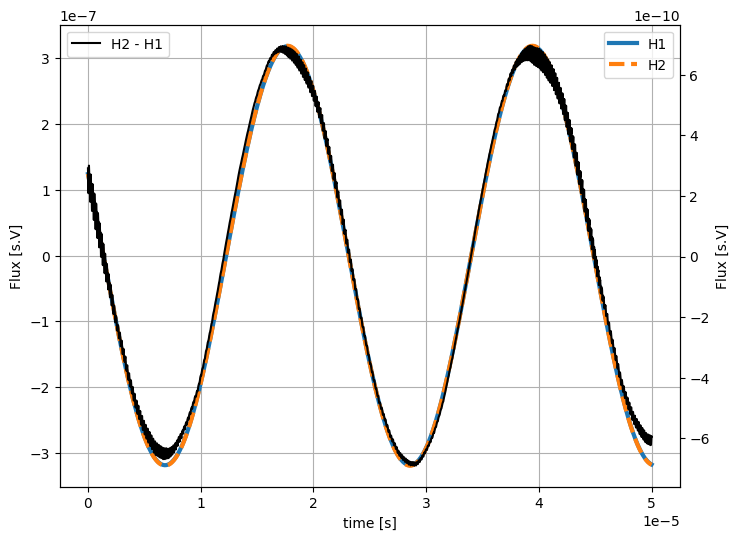

In [20]:
#@title Syncronize H1 and H2

def sync_phase(h1, h2, p1, p2, rate=1.0):
  phi1 = p1[1]
  phi2 = p2[1]
  dphi = phi1 - phi2
  print(f"dphi = {dphi*180:.3g}deg.")
  if dphi > np.pi:
    dphi = dphi - 2*np.pi
  elif dphi < -1 * 2*np.pi:
    dphi = dphi + np.pi
  print(f"re_dphi = {dphi*180:.3g}deg.")
  del_t = np.abs(dphi) / (2 * np.pi * f) * rate
  print(f"del_t = {del_t:.3g} [s]")
  if dphi >= 0:
    n = len(h1)
    h2 = h2[h2['time'] >= del_t].copy()
    h2['time'] = h2['time'] - del_t
    h1 = h1.iloc[:(len(h2))]
    n_cut = n - len(h2)
    n_cut = -1 * n_cut
    h1 = h1.reset_index(drop=True)
    h2 = h2.reset_index(drop=True)
  else:
    n = len(h2)
    h1 = h1[h1['time'] >= del_t].copy()
    h1['time'] = h1['time'] - del_t
    h2 = h2.iloc[:(len(h1))]
    n_cut = n - len(h1)
    h1 = h1.reset_index(drop=True)
    h2 = h2.reset_index(drop=True)

  print(n_cut)
  dif = h2['fit_flux'] - h1['fit_flux']
  max_h1 = np.max(h1['fit_flux'])
  max_h2 = np.max(h2['fit_flux'])
  max_h = np.max([max_h1, max_h2])
  max_dif = np.max(np.abs(dif))
  print(f"diff = {max_dif/max_h * 100:.3f}%")
  fig, ax = plt.subplots(figsize=(8, 6))
  ax2 = ax.twinx()
  ax.grid(True)
  ax2.plot(h1['time'], dif, label=r"H2 - H1", color="black")
  ax.plot(h1['time'], h1['fit_flux'], label=r"H1", linewidth=3)
  ax.plot(h2['time'], h2['fit_flux'], label=r"H2", linestyle="--", linewidth=3)
  ax.set_xlabel("time [s]")
  ax.set_ylabel("Flux [s.V]")
  ax2.set_ylabel("Flux [s.V]")
  ax.legend()
  ax2.legend(loc=2)
  plt.show()
  return h1, h2, n_cut

dif_time_rate = 1.0 #@param {type:"number"}

H1_sync, H2_sync, n_dif = sync_phase(H1, H2, H1_popt, H2_popt, rate=dif_time_rate)

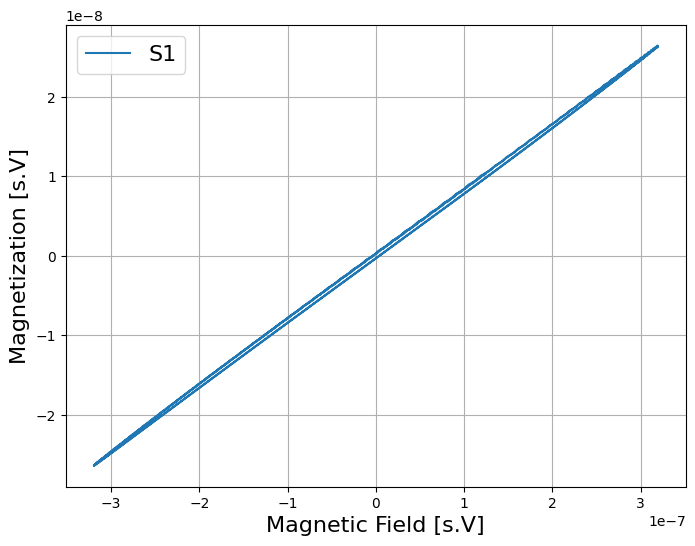

In [26]:
#@title plot M-H

if n_dif > 0:
  Mg_sync = Mg.iloc[:(len(Mg) - n_dif)].copy()
  Mg_sync = Mg_sync.reset_index(drop=True)
  Mg_sync['fit_flux'] = Mg_sync['fit_flux'] - BG[:(len(Mg) - n_dif)]['fit_flux']
else:
  n_dif = -1 * n_dif
  Mg_sync = Mg.iloc[n_dif:].copy()
  Mg_sync['time'] = Mg_sync['time'] - Mg_sync['time'].iloc[0]
  Mg_sync = Mg_sync.reset_index(drop=True)
  Mg_sync['fit_flux'] = Mg_sync['fit_flux'] - BG[n_dif:]['fit_flux']

fig, ax = plt.subplots(figsize=(8, 6))

T = H1_sync['time']
T = T - T[0]
H = H2_sync['fit_flux']
M = Mg_sync['fit_flux']

out_df = pd.DataFrame({"T": T, "H": H, "M": M})
out_df.to_csv(f"result/{condition[0]}kHz_{condition[1]}mT_{condition[2]}.csv", index=False)

ax.grid(True)
ax.plot(H, M, label=condition[2],)

ax.set_xlabel("Magnetic Field [s.V]", fontsize=16)
ax.set_ylabel("Magnetization [s.V]", fontsize=16)
ax.legend(fontsize=16)
plt.show()


In [27]:
out_df

,T,H,M
0,0.000000e+00,1.244139e-07,1.030451e-08
1,2.000000e-10,1.243968e-07,1.030288e-08
2,4.000000e-10,1.243796e-07,1.030127e-08
3,6.000000e-10,1.243625e-07,1.029966e-08
4,8.000000e-10,1.243454e-07,1.029807e-08
...,...,...,...
249993,4.999860e-05,-3.179209e-07,-2.624462e-08
249994,4.999880e-05,-3.179226e-07,-2.624532e-08
249995,4.999900e-05,-3.179242e-07,-2.624602e-08
249996,4.999920e-05,-3.179258e-07,-2.624671e-08
